In [40]:
import spacy
import json
import datetime
import ast
import numpy as np
import pandas as pd

from gensim.utils import ClippedCorpus
from gensim.models import Phrases, CoherenceModel
from gensim import corpora, models

from pymongo import MongoClient
from itertools import chain

In [2]:
'''import sys
sys.path.append('../..')

from core_modules.topic_extraction.lda_utils import LdaUtils
from core_modules.topic_extraction.nlp_utils import NLPUtils
from core_modules.topic_extraction.lda_module import LdaModule'''

# Connection to mongo

In [3]:
mongourl = "mongodb://localhost:27017"
mongo_client = MongoClient(mongourl)

collection = mongo_client["news"]["article"]
not_processed_docs = collection.find(
    {
        "$or": [
            {"processedEncoding": False},
            {"processedEncoding": {"$exists": False}},
        ]
    }
).limit(100)

# Pre-processing documents

In [5]:
nlp = spacy.load("en_core_web_md")

In [10]:
def fix_stop_words():
    for word in nlp.Defaults.stop_words:
        nlp.vocab[word].is_stop = True
    return

def add_custom_stop_words(custom_stop_words):
    for cw in custom_stop_words:
        nlp.vocab[cw].is_stop = True
    return

def sentence_tokenize(data):
    return [sent for sent in data.sents]

def lemmatize_tokens(data):
    lemmas = []
    for sent in data:
        lemmas.append(
            [
                token.lemma_
                for token in sent
                if (
                    not nlp.vocab[token.lower_].is_stop
                    and not token.is_punct
                    and len(token.text) > 1
                )
            ]
        )
    return lemmas

def flatten_list(data):
    return list(chain.from_iterable(data))

fix_stop_words()

In [11]:
def parse_text(raw_data):
    doc = nlp(raw_data)
    # Retrieve sentences
    sentences = sentence_tokenize(doc)
    # print(len(sentences))
    # Lemmatize + remove stop words
    lemmas = lemmatize_tokens(sentences)
    # print(len(lemmas))
    # Flatten results into a single list
    parsed_text = flatten_list(lemmas)

    return parsed_text

Create list with parsed documents

In [14]:
documents = []
for doc in not_processed_docs:
    parsed_doc = parse_text(doc["text"])
    documents.append(parsed_doc)

# LDA utility functions

In [23]:
def get_word_collocations(tokens):
    bigrams = Phrases(tokens)
    trigrams = Phrases(bigrams[tokens], min_count=1)
    return list(trigrams[bigrams[tokens]])

def string_to_list(tokens):
    return ast.literal_eval(tokens)

def save_lda_model(ldaModule, location):
    with open(location + ".pickle", "wb") as output:
        pickle.dump(ldaModule, output, pickle.HIGHEST_PROTOCOL)

def load_lda_model(location):
    with open(location + ".pickle", "rb") as input_file:
        ldaModule = pickle.load(input_file)
    return ldaModule

# LDA Module implementation

In [75]:
def build_dictionary(doc_collection, use_collocations=True, doc_threshold=3):
    if use_collocations:
        doc_collection = get_word_collocations(doc_collection)
    else:
        doc_collection = [string_to_list(t) for t in doc_collection]

    dictionary = corpora.Dictionary(doc_collection)

    if doc_threshold > 0:
        dictionary.filter_extremes(no_below = doc_threshold)

    return dictionary

def build_corpus(doc_collection, dictionary):
    corpus = [dictionary.doc2bow(list_of_tokens) for list_of_tokens in doc_collection]
    return corpus

def build_lda_model(corpus, dictionary, num_topics = 20, passes = 4, alpha = 0.01, eta = 0.01):
    model = models.LdaModel(corpus,
                            num_topics = num_topics,
                            id2word = dictionary,
                            passes = passes,
                            alpha = [alpha] * num_topics,
                            eta = [eta] * len(dictionary.keys()))
    return model

def get_topics(model, corpus, num_docs):
    topics = [model[corpus[i]] for i in range(num_docs)]
    return topics

In [76]:
dictionary = build_dictionary(documents)
corpus = build_corpus(documents, dictionary)

# Topic Coherence

In [77]:
def compute_coherence_values(documents, corpus, dictionary, k, a, b, passes):
    model = build_lda_model(corpus, 
                            dictionary, 
                            num_topics = k,
                            passes = passes,
                            alpha = a,
                            eta = b)
    coherence_model_lda = CoherenceModel(model = model, 
                                         texts = documents, 
                                         dictionary = dictionary, 
                                         coherence='c_v')
    return coherence_model_lda.get_coherence()

In [78]:
# Topics range
min_topics = 2
max_topics = 11
topics_range = range(min_topics, max_topics)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))

In [79]:
num_docs = len(corpus)
corpus_sets = [#ClippedCorpus(corpus, num_docs*0.25), 
               #ClippedCorpus(corpus, num_docs*0.5), 
               ClippedCorpus(corpus, int(num_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']

In [80]:
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [ ]:
# LDA model training passes
passes = 10

# iterate through validation corpuses
for i in range(len(corpus_sets)):
    # iterate through number of topics
    print("~"*30)
    print("Starting corpus set {}".format(i))
    print("~"*30)
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(documents, 
                                              corpus = corpus_sets[i], 
                                              dictionary = dictionary, 
                                              k = k, a = a, b = b, passes = passes)
                # Save the model results
                model_results['Validation_Set'].append(corpus_title[i])
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)

In [102]:
res = pd.read_csv('lda_tuning_results.csv')
res.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.290538
1,75% Corpus,2,0.01,0.31,0.279537
2,75% Corpus,2,0.01,0.61,0.322594
3,75% Corpus,2,0.01,0.91,0.248673
4,75% Corpus,2,0.31,0.01,0.294793


In [103]:
#res['Validation_Set'] = res['Validation_Set'].map(lambda x: 75 if x == "75% Corpus" else 100)
res_75 = res[res['Validation_Set'] == "75% Corpus"]
res_100 = res[res['Validation_Set'] == "100% Corpus"]

In [105]:
print(len(res_75))
print(len(res_100))

144
144


In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

In [108]:
sns.set(style="darkgrid")

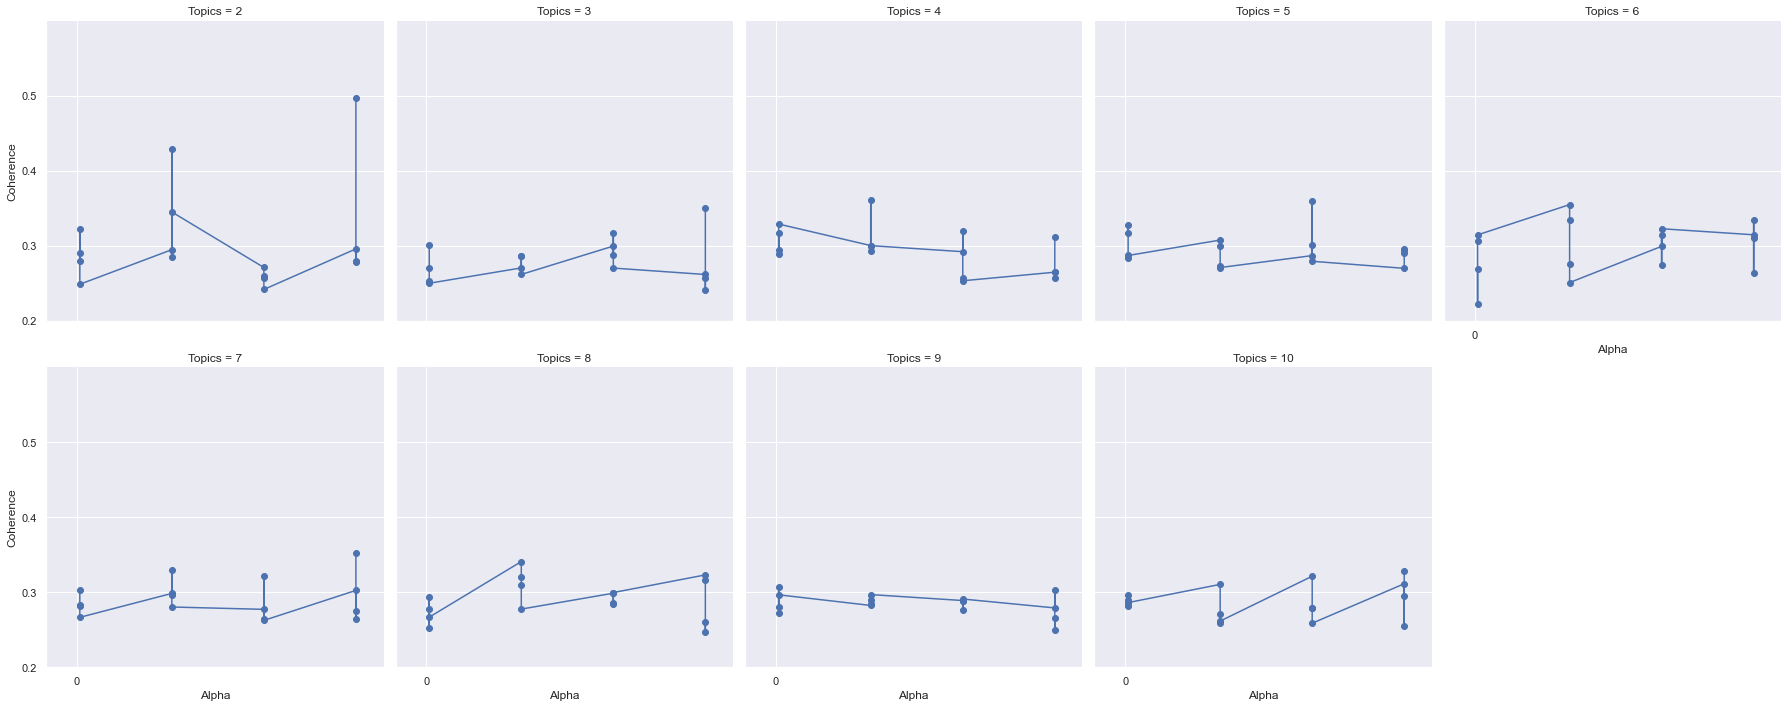

In [129]:
grid = sns.FacetGrid(res_75, col="Topics", palette="tab20c", col_wrap=5, height=5)
grid.map(plt.plot, "Alpha", "Coherence", marker="o")
grid.set(xticks=np.arange(1), yticks=[0.1, 0.2, 0.3, 0.4, 0.5],
         xlim=(-0.1, 1), ylim=(0.2, 0.6))
grid.fig.tight_layout(w_pad=1)